In [192]:
import arviz as az
import numpy as np
import os.path as op
import pandas as pd

import seaborn as sns
from bauer.utils.plotting import plot_prediction
import matplotlib.pyplot as plt
from tms_risk.utils import get_subjects
from tms_risk.cogmodels.fit_model import build_model, get_data
from bauer.utils.math import softplus_np
from tms_risk.cogmodels.utils import plot_ppc

from bauer.models import FlexibleSDRiskRegressionModel

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)


def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return FlexibleSDRiskRegressionModel.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

bids_folder = '/data/ds-tmsrisk'

# Get dip in noisiness between 7 and 18

In [193]:
df = get_data(model_label='flexible1')
model = build_model(df=df, model_label='flexible1')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible1_trace.netcdf'))

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [194]:
n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

x = np.(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/2540671200.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/2540671200.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/2540671200.py:2: FutureWarning: In a future version of pandas all arguments of concat except for th

In [195]:
curve_posterior.loc[2, 7:22].groupby(['subject', 'TMS']).mean().mean(1).unstack('TMS').corr()

TMS,IPS,Vertex
TMS,,
IPS,1.000000,0.896822
Vertex,0.896822,1.000000


In [196]:
diff = curve_posterior.xs('IPS', 0, 'TMS') - curve_posterior.xs('Vertex', 0, 'TMS')

<Axes: ylabel='Count'>

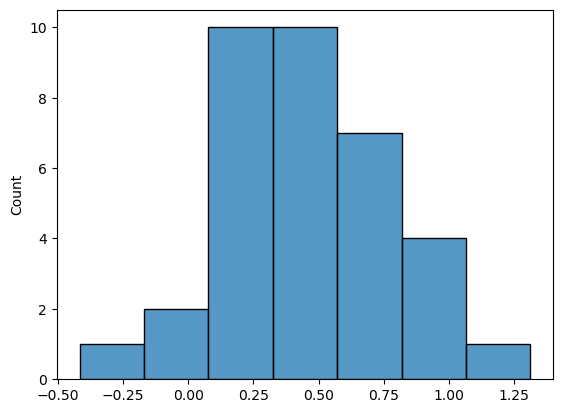

In [198]:
cognitive_ips_effect = diff.loc[2, 7:22].groupby('subject').mean().mean(1)
sns.histplot(cognitive_ips_effect)

# Compare to amplitude dip


In [199]:
from tqdm.contrib.itertools import product
from tms_risk.utils import get_tms_conditions

subjects = get_subjects(all_tms_conditions=True)

pars = []
keys = []

for sub, session, roi in product(subjects, [2,3], ['NPCr2cm-cluster']):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi, keys=['mu', 'amplitude', 'cvr2', 'r2']))
        keys.append((sub.subject, session, roi))
    except Exception as e:
        print(e)

pars = pd.concat(pars, keys=keys, names=['subject', 'session', 'roi'])
tms_conditions = get_tms_conditions()

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)


  0%|          | 0/70 [00:00<?, ?it/s]

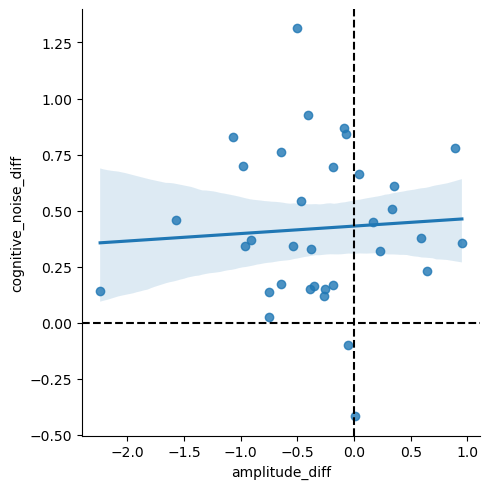

In [200]:
tmp = pars[pars.cvr2 > 0.0]

amplitude_diff = tmp.groupby(['subject', 'stimulation_condition'])['amplitude'].mean().unstack()
amplitude_diff = amplitude_diff['ips'] - amplitude_diff['vertex']
amplitude_diff.index = amplitude_diff.index.astype(int)

diffs = amplitude_diff.to_frame('amplitude_diff').join(cognitive_ips_effect.to_frame("cognitive_noise_diff"))

sns.lmplot(x='amplitude_diff', y='cognitive_noise_diff', data=diffs.reset_index(), robust=True)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

In [201]:
tmp.groupby(['subject', 'stimulation_condition']).mean()['amplitude'].unstack('stimulation_condition').corr()

stimulation_condition,ips,vertex
stimulation_condition,,
ips,1.000000,0.472164
vertex,0.472164,1.000000


In [202]:
import pingouin
pingouin.corr(diffs['amplitude_diff'], diffs['cognitive_noise_diff'])

,n,r,CI95%,p-val,BF10,power
pearson,34,0.039196,"[-0.3, 0.37]",0.825803,0.218,0.05516


In [203]:
pingouin.ttest(diffs['amplitude_diff'], 0.0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.706309,33,two-sided,0.010686,"[-0.54, -0.08]",0.464128,4.08,0.747577


,n,r,CI95%,p-val,BF10,power
pearson,35,-0.018392,"[-0.35, 0.32]",0.916484,0.211,0.050828


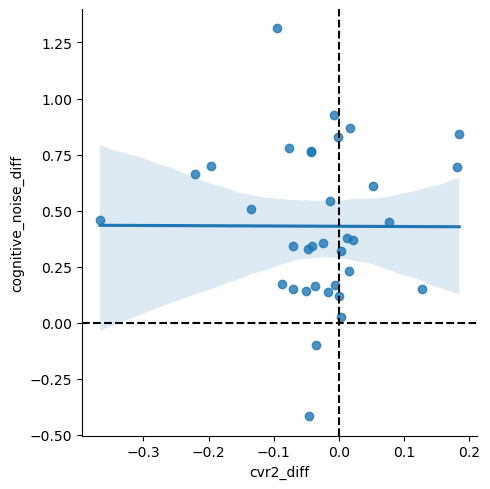

In [204]:
cvr2_diff = (pars['cvr2'] > 0.0).groupby(['subject', 'stimulation_condition']).mean().unstack('stimulation_condition')
cvr2_diff = cvr2_diff['ips'] - cvr2_diff['vertex']

cvr2_diff.index = cvr2_diff.index.astype(int)

diffs = cvr2_diff.to_frame('cvr2_diff').join(cognitive_ips_effect.to_frame("cognitive_noise_diff"))

sns.lmplot(x='cvr2_diff', y='cognitive_noise_diff', data=diffs.reset_index(), robust=True)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')


pingouin.corr(diffs['cvr2_diff'], diffs['cognitive_noise_diff'])

In [205]:
diff_amplitude_bayes = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'diff_amplitude.tsv'), sep='\t', index_col=0)


diffs_ = diff_amplitude_bayes.join(cognitive_ips_effect.to_frame("cognitive_noise_diff"))

pingouin.corr(diffs_['diff_amplitude'], diffs_['cognitive_noise_diff'])

,n,r,CI95%,p-val,BF10,power
pearson,35,0.059982,"[-0.28, 0.39]",0.73214,0.223,0.063203


In [206]:
amplitude_diff.to_frame('amplitude_diff_freq').join(diff_amplitude_bayes).corr()

,amplitude_diff_freq,diff_amplitude
amplitude_diff_freq,1.000000,0.674966
diff_amplitude,0.674966,1.000000


# Compare to decoding dip

In [207]:
from tms_risk.utils.data import get_pdf, get_decoding_info, get_all_behavior


subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
# masks = ['NPCr1cm-surface', 'NPCr1cm-cluster', 'NPCr2cm-surface', 'NPCr2cm-cluster']
# n_voxels = [0, 1, 100]
masks = ['NPCr2cm-cluster']
n_voxels = [1]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/70 [00:00<?, ?it/s]

In [208]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/884262180.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [209]:
decoding_diff = r2.droplevel('session').unstack('stimulation_condition')['r']
decoding_diff = (decoding_diff['ips'] - decoding_diff['vertex']).to_frame('decoding_diff')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/3963465035.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(decoding_diff)


<Axes: ylabel='Density'>

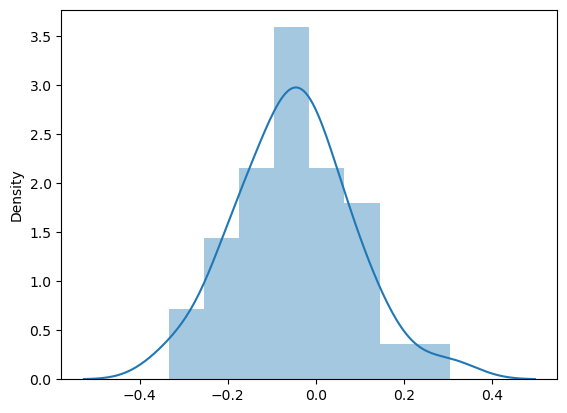

In [217]:
sns.distplot(decoding_diff)

In [210]:
diffs = cognitive_ips_effect.to_frame('cognitive_ips_effect').join(decoding_diff).join(amplitude_diff.to_frame('amplitude_diff'))

,n,r,CI95%,p-val,BF10,power
pearson,35,0.152177,"[-0.19, 0.46]",0.38283,0.303,0.141514


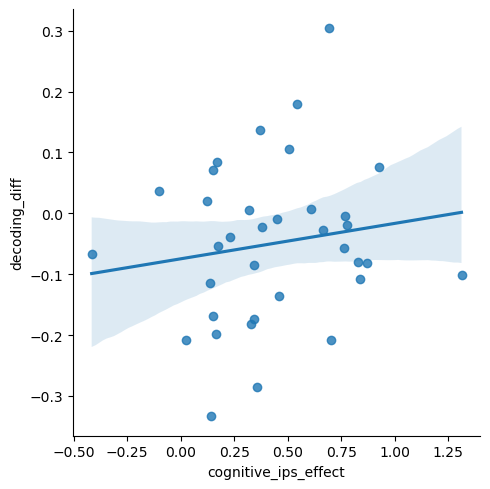

In [211]:
sns.lmplot(diffs, x='cognitive_ips_effect', y='decoding_diff')

pingouin.corr(diffs['cognitive_ips_effect'], diffs['decoding_diff'])

In [212]:
diffs.corr()

,cognitive_ips_effect,decoding_diff,amplitude_diff
cognitive_ips_effect,1.000000,0.152177,0.039196
decoding_diff,0.152177,1.000000,0.293859
amplitude_diff,0.039196,0.293859,1.000000


In [213]:
r2.droplevel('session').unstack('stimulation_condition')['r'].corr()

stimulation_condition,ips,vertex
stimulation_condition,,
ips,1.000000,0.406569
vertex,0.406569,1.000000


In [214]:
pingouin.power_corr(n=35, alpha=0.05, power=0.8)

0.453626017535738

In [215]:
r2.droplevel('session').unstack('stimulation_condition')['r']

,,,,,stimulation_condition,ips,vertex
subject,pca,glm,smoothed,mask,n_voxels,,
1,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,0.024520,0.077764
2,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,-0.103584,0.182301
3,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,0.307780,0.127747
4,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,0.124063,0.146527
5,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,-0.020636,0.161589
6,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,-0.000955,0.172429
7,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,-0.032402,0.300763
9,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,-0.082798,0.125200
10,no pca,GLMstim,not smoothed,NPCr2cm-cluster,1,0.142570,0.341158


# Flexible model 2

In [225]:
df = get_data(model_label='flexible2')
model = build_model(df=df, model_label='flexible2')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible2_trace.netcdf'))

memory_noise_sd_ips = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
memory_noise_sd_vertex = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

x = np.arange(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)



for d in [memory_noise_sd_ips, memory_noise_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat([memory_noise_sd_ips, memory_noise_sd_vertex], axis=0,
                        keys=[('memory', 'IPS'), ('memory', 'Vertex')], names=['noise', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/1571624539.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  memory_noise_sd_ips = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/1571624539.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  memory_noise_sd_vertex = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_8438/1571624539.py:7: FutureWarning: In a future version of pandas all arguments of concat except f

[(0.0, 4.0)]

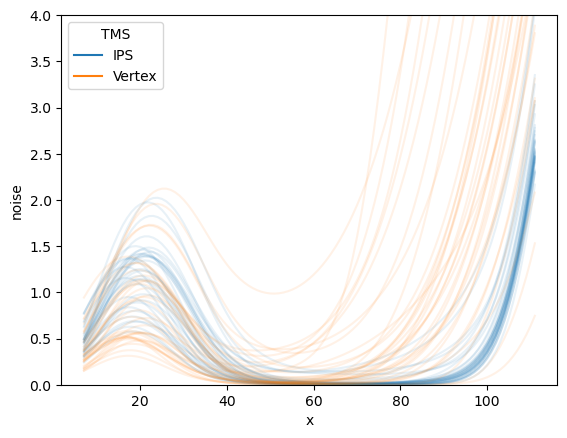

In [259]:
tmp = curve_posterior.groupby(['subject', 'TMS']).mean().stack().to_frame('noise')

g = sns.lineplot(data=tmp.reset_index(), x='x', y='noise', hue='TMS',  units="subject", estimator=None, alpha=.1)

g.set(ylim=(0, 4))

In [242]:
flexible2_noise_diff = curve_posterior.loc[:, 12:28].mean(1).unstack('TMS')
flexible2_noise_diff = flexible2_noise_diff['IPS'] - flexible2_noise_diff['Vertex']
flexible2_noise_diff = flexible2_noise_diff.groupby('subject').mean().to_frame('flexible2_noise_diff')

In [247]:
cognitive_ips_effect.to_frame('flexible1_noise_diff').join(flexible2_noise_diff).corr()

,flexible1_noise_diff,flexible2_noise_diff
flexible1_noise_diff,1.000000,0.257447
flexible2_noise_diff,0.257447,1.000000


In [250]:
tmp = amplitude_diff.to_frame('amplitude_diff').join(flexible2_noise_diff)

pingouin.corr(tmp['amplitude_diff'], tmp['flexible2_noise_diff']) 

,n,r,CI95%,p-val,BF10,power
pearson,34,-0.059867,"[-0.39, 0.28]",0.736625,0.225,0.06272


In [252]:
tmp = decoding_diff.join(flexible2_noise_diff)

pingouin.corr(tmp['decoding_diff'], tmp['flexible2_noise_diff']) 

,n,r,CI95%,p-val,BF10,power
pearson,35,0.002842,"[-0.33, 0.34]",0.98707,0.21,0.049587
